In [2]:
#downloading the IMDB data as a raw text

import os

imdb_dir="C:/Users/heikkila.SYSTEM-EXE/Desktop/AI/study/deep_learning_with_python/NLP/aclImdb/aclImdb"
train_dir = os.path.join(imdb_dir, 'train')

#creating arrays for texts and labels
labels = []
texts = []

#adding texts from downloaded text files to array that we created previously
#additionaly, adding labels to labels array
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8_sig")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [3]:
#vectorizing the text and preparing a training and validation split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

#cuts off reviews after 100 words
maxlen = 100

#trains on 200 samples
training_samples = 200

#validates on 10,000 samples
validation_samples = 10000

#considers only the top 10,000  words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)

#updating internal vocabulary based on a list of texts
#required before using texts_to_sequences or texts_to_matrix
tokenizer.fit_on_texts(texts)

#updating internal vocabulary based on a list of sequences
#required before using sequences_to_matrix (if fit_on_texts was never called)
sequences = tokenizer.texts_to_sequences(texts)

# 単語ごとに割り当て当てられたインデックス番号
word_index = tokenizer.word_index
print('found %s unique tokens.' % len(word_index))

#padding sequences to the same length
#sequences must all be the same length
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('shape of data tensor:', data.shape)
print('shape of label tensor:', labels.shape)

#shuffle the data because in the data samples are ordered(all negative first, then all positive)
#np.arange returns evenly spaced values within a given interval(in this case, only start point is set)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

#splitting data into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


found 88582 unique tokens.
shape of data tensor: (25000, 100)
shape of label tensor: (25000,)


In [4]:
#preprocessing the embaddings

glove_dir = "C:/Users/heikkila.SYSTEM-EXE/Desktop/AI/study/deep_learning_with_python/NLP/glove.6B"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf-8_sig")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.' % len(embeddings_index))
 

found 400000 word vectors.


In [5]:
#preparing the GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector= embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0406 14:10:03.966289 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0406 14:10:04.006652 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0406 14:10:04.023606 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [7]:
#loading the glove matrix into embedding layer of model

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0406 14:10:09.362334 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0406 14:10:09.362334 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [8]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history=model.fit(x_train, y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

W0406 14:10:12.120754 22416 deprecation_wrapper.py:119] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0406 14:10:12.163641 22416 deprecation.py:323] From C:\Users\heikkila.SYSTEM-EXE\anaconda3\envs\tensorflowcpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 2.4091 - acc: 0.4950 - val_loss: 0.8364 - val_acc: 0.5033
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6589 - acc: 0.6600 - val_loss: 0.6888 - val_acc: 0.5541
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4281 - acc: 0.8650 - val_loss: 0.8202 - val_acc: 0.5194
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3650 - acc: 0.8350 - val_loss: 0.9353 - val_acc: 0.5165
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1546 - acc: 0.9700 - val_loss: 1.0943 - val_acc: 0.5161
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3757 - acc: 0.8100 - val_loss: 1.0511 - val_acc: 0.5114
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0681 - acc: 1.0000 - val_loss: 0.9225 - val_acc: 0.5253
Epoch 8/10
200/200 [========

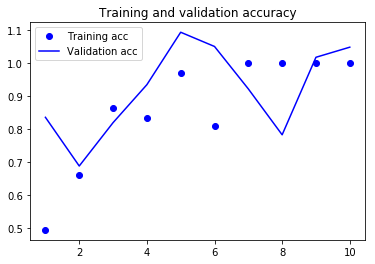

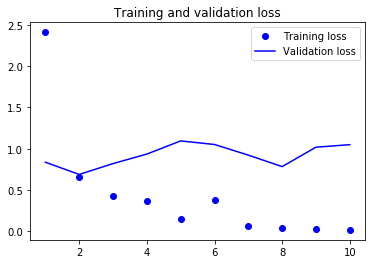

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
#trying to train model witout importing pretrained imbeddings

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history=model.fit(x_train, y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6901 - acc: 0.5700 - val_loss: 0.6906 - val_acc: 0.5253
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5001 - acc: 0.9600 - val_loss: 0.6923 - val_acc: 0.5249
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2748 - acc: 1.0000 - val_loss: 0.7057 - val_acc: 0.5231
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1248 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.5143
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0615 - acc: 1.0000 - val_loss: 0.7181 - val_acc: 0.5228
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0311 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.5304
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0174 - acc: 1.0000 - val_loss: 0.7364 - val_acc: 0.5243
Epoch 8/10
200/200 [========

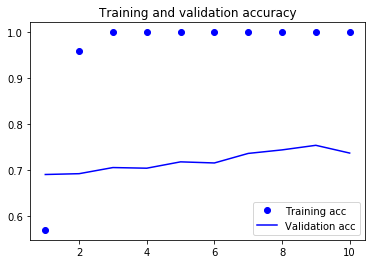

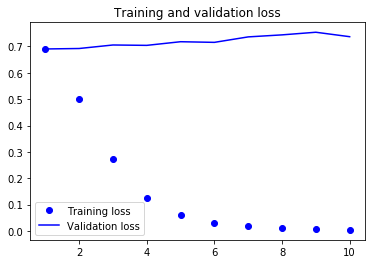

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
#tokenizing the test data

test_dir=os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8_sig')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [14]:
#evaluating the model

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 62us/step


[1.0623291460323334, 0.52756]

In [15]:
prediction = model.predict(x_test)

In [16]:
y_test[0]

0

In [17]:
prediction[:]

array([[0.65100855],
       [0.9655089 ],
       [0.29205748],
       ...,
       [0.96568215],
       [0.22825736],
       [0.93900514]], dtype=float32)

In [ ]:
#for test